In [1]:
import os, sys,shutil, gc

from glob import glob
from tqdm import tqdm

import math
import random
from collections import OrderedDict
import warnings

import albumentations as A
import cv2
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import timm
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW,lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import fbeta_score, average_precision_score, roc_auc_score

import multiprocessing

from ink_helpers import (load_image,seed_everything,
                         load_fragment, DiceLoss, FocalLoss, dice_bce_loss)
from resnet3d import generate_model

warnings.simplefilter("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
print("cpu count:", multiprocessing.cpu_count())

cuda
cpu count: 32


In [2]:
# Config:
random_seed = 42
num_workers = min(12, multiprocessing.cpu_count())

bottom_channel_idx = 7
top_channel_idx = 33
num_fluctuate_channel = 1

num_select_channel = top_channel_idx - bottom_channel_idx

block_size = 256
stride = 128
kernel_size = 201

loss_type = ['bce', 'focal', 'bcedice'][2]
max_lr = 5.0e-5
weight_decay = 1.0e-3
total_epoch = 8
batch_size = 12

model_depth = 50

valid_id_list = ['2c']

seed_everything(seed=random_seed)

In [3]:
all_frag_ids = ['1', '2a', '2b', '2c', '3']
id2dir = {id:f'./frags/train_{id}' for id in all_frag_ids}
train_id_list = [id for id in all_frag_ids if id not in valid_id_list]
print('Train:', train_id_list)

Train: ['1', '2a', '2b', '3']


In [4]:
id2images,id2frag_mask,id2ink_mask = {},{},{}
for frag_id in tqdm(all_frag_ids):
    _,frag_mask,ink_mask = load_fragment(frag_id)
    id2images[frag_id] = np.load(f'{id2dir[frag_id]}/landscape_peel_surface_kernel{kernel_size}_top17_bottom18.npy')
    id2frag_mask[frag_id] = frag_mask
    id2ink_mask[frag_id] = ink_mask

100%|█████████████████████████████████████████████| 5/5 [01:15<00:00, 15.17s/it]


In [5]:
class InkDataSet3D(Dataset):
    '''
    image: (D, H, W); mask: (1, H, W)
    '''
    def __init__(self, frag_id_list, block_size, channel_slip=0, transforms=None, has_label=True):
        self.frag_id_list = frag_id_list
        self.block_size = block_size
        self.transforms = transforms
        self.has_label = has_label
        
        # get xy positions
        id_xybt_list = []
        for frag_id in frag_id_list:
            frag_mask = id2frag_mask[frag_id]
            xy_pairs = [
                (min(x,frag_mask.shape[1]-block_size), min(y,frag_mask.shape[0]-block_size))
                for x in range(0, frag_mask.shape[1]-block_size+stride, stride) 
                for y in range(0, frag_mask.shape[0]-block_size+stride, stride) 
                if np.any(frag_mask[y:y+block_size, x:x+block_size] > 0)
            ]
            bt_pairs = [(bottom_channel_idx+f, top_channel_idx+f)
                        for f in range(-channel_slip, channel_slip+1)]
            id_xybt_list += [(frag_id, *xy, *bt) for xy in xy_pairs for bt in bt_pairs]
        self.id_xybt_list = id_xybt_list
        
    def __len__(self):
        return len(self.id_xybt_list)

    def __getitem__(self, idx):
        frag_id,x,y,start_z,end_z = self.id_xybt_list[idx]

        whole_image = id2images[frag_id]
        image = whole_image[start_z:end_z, 
                            y:y+self.block_size, 
                            x:x+self.block_size] # D,H,W
        image = np.moveaxis(image, 0, 2) # H,W,D

        if self.has_label:
            whole_mask = id2ink_mask[frag_id]
            mask = whole_mask[y:y+self.block_size, 
                              x:x+self.block_size] # H,W
            
            if self.transforms:
                transformed = self.transforms(image=image, mask=mask)
                image, mask = transformed['image'], transformed['mask']
                
            image = np.moveaxis(image, 2, 0) # D,H,W
            image = np.expand_dims(image, 0) # 1,D,H,W
            mask = np.expand_dims(mask, 0) # 1,H,W
            return idx, image, mask
        else:
            if self.transforms:
                image = self.transforms(image=image)['image']
            image = np.moveaxis(image, 2, 0) # D,H,W
            image = np.expand_dims(image, 0) # 1,D,H,W
            return idx,image

In [6]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=1.0),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(block_size * 0.3), max_height=int(block_size * 0.3), 
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean=[0]*num_select_channel, 
            std=[1]*num_select_channel
        ),
    ]
)

train_dataset = InkDataSet3D(
    frag_id_list=train_id_list, 
    block_size=block_size, 
    channel_slip=num_fluctuate_channel, 
    transforms=train_transform, 
    has_label=True
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    prefetch_factor=1,
)

valid_transform = A.Compose([
        A.Normalize(
            mean=[0]*num_select_channel, 
            std=[1]*num_select_channel
        ),
    ]
)

valid_dataset = InkDataSet3D(
    frag_id_list=valid_id_list, 
    block_size=block_size, 
    channel_slip=0, 
    transforms=valid_transform, 
    has_label=False
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    prefetch_factor=1,
)

print('Train', len(train_dataloader), ', Valid', len(valid_dataloader), )

Train 1998 , Valid 175


# Model

In [7]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], 
                          encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel3D(nn.Module):
    def __init__(self, model_depth=34):
        super().__init__()
        self.model_depth = model_depth
        self.encoder = generate_model(model_depth=model_depth, n_input_channels=1)
        if model_depth<50:
            encoder_dims = [64, 128, 256, 512]
        else:
            encoder_dims = [256, 512, 1024, 2048]
        self.decoder = Decoder(encoder_dims=encoder_dims, upscale=4)
        
    def forward(self, x):
        feature_maps = self.encoder(x)
        feature_maps_pooled = [torch.mean(f, dim=2) for f in feature_maps]
        pred_mask = self.decoder(feature_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))
    

In [8]:
model = SegModel3D(model_depth);
if model_depth<=34:
    pretrain_fn = f"r3d{model_depth}_KM_200ep.pth"
else:
    pretrain_fn = f"r3d{model_depth}_KMS_200ep.pth"
model.load_pretrained_weights(torch.load(pretrain_fn)["state_dict"])
model.to(device);

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [9]:
if loss_type == 'bce':
    criterion = nn.BCEWithLogitsLoss()
elif loss_type == 'focal':
    criterion = FocalLoss(alpha=1, gamma=2, use_logits=True)
if loss_type == 'bcedice':
    criterion = dice_bce_loss
    
    
optimizer = AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    epochs=total_epoch,
    steps_per_epoch=int(len(train_dataloader)*1.15),
    max_lr=max_lr,
    pct_start=0.3,
    anneal_strategy="cos",
    div_factor=1.0e2,
    final_div_factor=1.0e1,
)
scaler = GradScaler()
Sig = nn.Sigmoid()

experiment_name = (
    f'Surface{kernel_size}-ResNet3D-depth{model.model_depth}-block{block_size}-channel{bottom_channel_idx}'
    f'-to{top_channel_idx}-slip{num_fluctuate_channel}-loss{loss_type}-lr{max_lr}-wd{weight_decay}-bs{batch_size}'
    f'-valid{"+".join(valid_id_list)}-step{total_epoch*len(train_dataloader)}-seed{random_seed}-epoch{total_epoch}'
)

loss_list = [1] * 10
for epoch in range(total_epoch):
    
    # training
    gc.collect()
    with tqdm(enumerate(train_dataloader), total=len(train_dataloader)) as pbar:
        for step, (idx, img, target) in pbar:
            
            img, target = img.to(device).float(), target.to(device).float()
            
            optimizer.zero_grad()
            with autocast():
                outputs = model(img).float()
                loss = criterion(outputs, target)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            pbar.set_description(f"Ep{epoch:02d}")
            loss_list = loss_list[1:] + [loss.item()]
            pbar.set_postfix(
                OrderedDict(
                    LR=f"{scheduler.get_last_lr()[0]:.1e}",
                    Loss=f"{sum(loss_list)/10:.3f}",
                )
            )
            
            
    
    # validation
    if not len(valid_id_list):
        continue
    valid_frag_mask = id2frag_mask[valid_id_list[0]]
    valid_ink_mask = id2ink_mask[valid_id_list[0]]
    valid_ink_predicts = np.zeros(valid_frag_mask.shape).astype(float)
    valid_ink_count = np.zeros(valid_frag_mask.shape)
    valid_xybt_list = valid_dataset.id_xybt_list
    
    model.eval()
    for idx, img in tqdm(valid_dataloader):
        img = img.to(device).float()
        with torch.no_grad():
            with autocast():
                outputs = Sig(model(img).float())

        for batch_idx,whole_idx in enumerate(idx):
            x,y = map(int, valid_xybt_list[whole_idx][1:3])

            valid_ink_predicts[y:y+block_size, x:x+block_size] += outputs.cpu()[batch_idx][0].numpy()
            valid_ink_count[y:y+block_size, x:x+block_size] += 1
    
    valid_ink_count[np.where(valid_frag_mask==0)] = 1
    valid_ink_predicts = valid_ink_predicts/valid_ink_count
    valid_ink_predicts[np.where(valid_frag_mask==0)] = 0

    valid_ink_predicts_flat = valid_ink_predicts[np.where(valid_frag_mask)].flatten()
    valid_ink_mask_flat = valid_ink_mask[np.where(valid_frag_mask)].flatten()

    map_score = average_precision_score(valid_ink_mask_flat, valid_ink_predicts_flat)
    auc_score = roc_auc_score(valid_ink_mask_flat, valid_ink_predicts_flat)
    fhalf_score = fbeta_score(valid_ink_mask_flat, valid_ink_predicts_flat>0.5, beta=0.5)
    print(f'Valid: mAP {map_score:.2f}, AUC {auc_score:.2f}, F0.5 {fhalf_score:.2f}, ')
    model.train()
    
# save weights
torch.save(model.state_dict(), f'./weights/{experiment_name}.pth')
    
gc.collect()

100%|█████████████████████████████████████████| 175/175 [00:49<00:00,  3.51it/s]


Valid: mAP 0.48, AUC 0.80, F0.5 0.45, 


100%|█████████████████████████████████████████| 175/175 [00:49<00:00,  3.52it/s]


Valid: mAP 0.58, AUC 0.82, F0.5 0.61, 


100%|█████████████████████████████████████████| 175/175 [00:49<00:00,  3.51it/s]


Valid: mAP 0.62, AUC 0.85, F0.5 0.47, 


100%|█████████████████████████████████████████| 175/175 [00:49<00:00,  3.50it/s]


Valid: mAP 0.66, AUC 0.87, F0.5 0.66, 


100%|█████████████████████████████████████████| 175/175 [00:49<00:00,  3.51it/s]


Valid: mAP 0.66, AUC 0.88, F0.5 0.62, 


100%|█████████████████████████████████████████| 175/175 [00:50<00:00,  3.49it/s]


Valid: mAP 0.67, AUC 0.88, F0.5 0.63, 


100%|█████████████████████████████████████████| 175/175 [00:49<00:00,  3.51it/s]


Valid: mAP 0.69, AUC 0.89, F0.5 0.67, 


100%|█████████████████████████████████████████| 175/175 [00:49<00:00,  3.51it/s]


Valid: mAP 0.67, AUC 0.88, F0.5 0.64, 


0

In [10]:
if len(valid_id_list):
    np.save(f'valid_preds_{experiment_name}.npy', valid_ink_predicts)
    for i in np.arange(0, 1, 0.1):
        print(i, fbeta_score(valid_ink_mask_flat, valid_ink_predicts_flat>i, beta=0.5))

0.0 0.2026294911659172
0.1 0.5499788892795285
0.2 0.5833796108790394
0.30000000000000004 0.6075449715547434
0.4 0.6250833438066259
0.5 0.6384942730864047
0.6000000000000001 0.6506125908080646
0.7000000000000001 0.6573099270961196
0.8 0.6585088333053006
0.9 0.6554890143093889


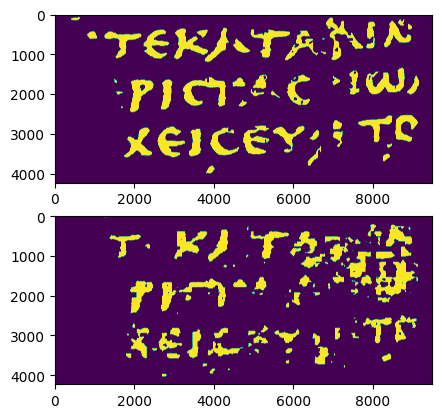

In [11]:
plt.subplot(2, 1, 1)
plt.imshow(valid_ink_mask)
plt.subplot(2, 1, 2)
plt.imshow(valid_ink_predicts>0.5)

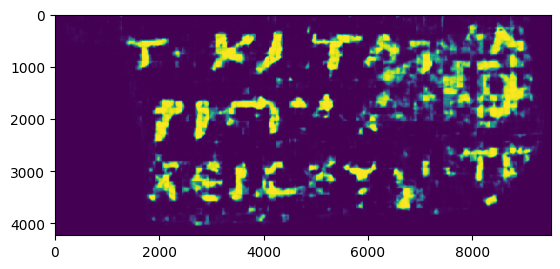

In [12]:
plt.imshow(valid_ink_predicts)